<a href="https://colab.research.google.com/github/ashishagg70/GANText2Image/blob/master/Text2Face_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 19DTv9tXIby7FW8TnU69u8xbNpcTWx6RG #list_attr_celeba.csv.zip
!gdown --id 1Z2nZ0sykKPn64BvzqrbwUjRFC4VqJAhm #annotated data Text2FaceAnnotation.json
!gdown --id 1tV-UAkyYh5KrPS2ieOZ6AxxmPLSS0vyo #stopword.txt

!gdown --id 1noTeR6FwEaSz8_KGCsBKkmSSLlVo7xgz #generator model
!gdown --id 1zdZRdsgWtRI0pN4C7qquHAZFd6-9SfEu #generator 100 epcohs
!gdown --id 1NwlAo2rdX_Z3f_m9WiVtTWXP1qFLTnYH #nn_ff_encode_filtered_16
!unzip list_attr_celeba.csv.zip

Downloading...
From: https://drive.google.com/uc?id=19DTv9tXIby7FW8TnU69u8xbNpcTWx6RG
To: /content/list_attr_celeba.csv.zip
2.12MB [00:00, 9.90MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Z2nZ0sykKPn64BvzqrbwUjRFC4VqJAhm
To: /content/Text2FaceAnnotation.json
100% 1.46M/1.46M [00:00<00:00, 6.79MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tV-UAkyYh5KrPS2ieOZ6AxxmPLSS0vyo
To: /content/stopwords_txt2attr.txt
100% 334/334 [00:00<00:00, 461kB/s]
Downloading...
From: https://drive.google.com/uc?id=1noTeR6FwEaSz8_KGCsBKkmSSLlVo7xgz
To: /content/Text2Face_filteredData_z130_Gen_wgan_e100_fulldata_attr
14.3MB [00:00, 39.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdZRdsgWtRI0pN4C7qquHAZFd6-9SfEu
To: /content/Text2Face_filteredData_z100_Gen_wgan_e100_fulldata_attr
14.3MB [00:00, 39.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NwlAo2rdX_Z3f_m9WiVtTWXP1qFLTnYH
To: /content/encoding_ff_model_filtered_16
24.6MB [00:01, 15.2MB/s]
Archive:  list

Downloading...
From: https://drive.google.com/uc?id=1zdZRdsgWtRI0pN4C7qquHAZFd6-9SfEu
To: /content/Text2Face_filteredData_z100_Gen_wgan_e100_fulldata_attr
14.3MB [00:00, 67.1MB/s]


In [ ]:
!pip install ffmpeg-python
!pip install SpeechRecognition
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install PyAudio
!pip install sounddevice

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import json
from collections import defaultdict
import tqdm 
import os
import string
from torchtext.vocab import GloVe
from PIL import Image
from torchvision.transforms import ToPILImage

import torchvision
import matplotlib.pyplot as plt


nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device.type == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
cpu


In [ ]:

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read,write as wav_write
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]
  sr, audio = wav_read(io.BytesIO(riff))
  wav_write('test.wav',sr,audio)

In [ ]:
EMB_DIM = 300
SENTENCE_LEN = 80
ATTRIBUTE_LEN = 16

encoding_size = 80
z_features = 20
imagePixel=64
leakyRelu_slope = 0.2 #default = 0.1

std=0.5
mean=0.5

json_filename='Text2FaceAnnotation.json'

In [ ]:
glove = GloVe('840B',EMB_DIM)

.vector_cache/glove.840B.300d.zip: 2.18GB [06:52, 5.28MB/s]                            
100%|█████████▉| 2195966/2196017 [04:22<00:00, 8827.71it/s]

In [ ]:
# list_attr_celeba = pd.read_csv("list_attr_celeba.csv")
list_att=['Arched_Eyebrows', 'Bald', 'Big_Lips', 'Black_Hair', 'Blond_Hair','Brown_Hair','Chubby', 'Gray_Hair', 'Heavy_Makeup', 'Male',  'Mustache', 'Smiling', 'Receding_Hairline', 'Wearing_Lipstick', 'Young','Eyeglasses']

In [ ]:
for i,j in enumerate(list_att):
    print(i+1,j)

1 Arched_Eyebrows
2 Bald
3 Big_Lips
4 Black_Hair
5 Blond_Hair
6 Brown_Hair
7 Chubby
8 Gray_Hair
9 Heavy_Makeup
10 Male
11 Mustache
12 Smiling
13 Receding_Hairline
14 Wearing_Lipstick
15 Young
16 Eyeglasses


In [ ]:
def word_encode(text):

    encoding =[]
    for sent in text:
        sent_encoding = np.zeros((SENTENCE_LEN,EMB_DIM))
        for idx,word in enumerate(sent):
            try:
                sent_encoding[idx] = glove[word]
            except Exception as e:
                print("Error: Embedding not found for",word)
                print(e)
        encoding.append(sent_encoding)
    return encoding

def convert_to_lower(text):
    return [i.lower() for i in text]

def remove_punctuation(text):
    return [i.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) for i in text]

def perform_tokenization(text):
    return [word_tokenize(i) for i in text]

def remove_stopwords(text):
    newtext = []
    f=open('stopwords_txt2attr.txt','r')
    lines=f.readlines()
    stopwordList = [line.rstrip() for line in lines]
    #print(stopwordList)
    for tokens in text:
        newtext.append([w for w in tokens if not w in stopwordList])
    return newtext

def text_preprocess(text):
    text = convert_to_lower(text)
    text = remove_punctuation(text)
    text = perform_tokenization(text)
    text = remove_stopwords(text)
    text = word_encode(text)
    return text

def denorm(image):
    return (image*std)+mean

In [ ]:
class nn_FF(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(EMB_DIM*SENTENCE_LEN, 256)
        self.linear2 = nn.Linear(256, ATTRIBUTE_LEN)
        self.activation = nn.ReLU()
        
    def forward(self,x, penultimate_neuron=False):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        t = self.activation(x)
        x = self.linear2(t)
        x = nn.Sigmoid()(x)
        if(penultimate_neuron):
            return t
        return x

In [ ]:
class nn_G(nn.Module):
    def __init__(self):
      super().__init__()
      self.no_of_conv_layers=np.log2(imagePixel//8).astype('int32')
      dim = imagePixel*8

      self.conv=[]
      self.bnorm=[]

      self.linearProjectionStart=nn.Linear(encoding_size+z_features,dim*4*4) #and reshaped to 512*4*4 in Text2FaceGAN paper 

      for i in range(self.no_of_conv_layers):
        self.conv.append(nn.ConvTranspose2d(dim,dim//2,4,stride=2, padding=1, bias=False))
        self.bnorm.append(nn.BatchNorm2d(dim//2))
        dim = dim//2
      self.conv=nn.ModuleList(self.conv)
      self.bnorm=nn.ModuleList(self.bnorm)
      assert dim == imagePixel
      self.conv_final = nn.ConvTranspose2d(dim,3,4,stride=2, padding=1, bias=False)   
    

    def forward(self,x):
      batch_size = x.shape[0]
      z = torch.randn(batch_size,z_features).to(device)
      x = torch.hstack((z,x))
      
      x = self.linearProjectionStart(x)
      x = x.view(-1, imagePixel*8, 4, 4)

      for i in range(self.no_of_conv_layers):
        x = self.conv[i](x)
        x = self.bnorm[i](x)
        x = nn.LeakyReLU(leakyRelu_slope)(x)
 
      x = self.conv_final(x)
      x = nn.Tanh()(x)

      return x

In [ ]:
file=open(json_filename,'r')
data=json.load(file)
descriptions=[]
filenames=[]
attributes=[]
for i,jsonElement in enumerate(data):
    descriptions.append(jsonElement['description'])
    filenames.append(jsonElement['filename'])
    attr = list_attr_celeba[list_attr_celeba['image_id'] == jsonElement['filename'] ][list_att].to_numpy().squeeze()
    attributes.append(attr)
attributes = torch.Tensor(attributes)
attributes[attributes<0] = 0
encodings = text_preprocess(descriptions)
encodings = torch.Tensor(encodings)

In [ ]:
nn_ff = torch.load('encoding_ff_model_filtered_16',map_location=torch.device('cpu'))
nn_gen = torch.load('Text2Face_filteredData_z130_Gen_wgan_e100_fulldata_attr',map_location=torch.device('cpu'))
nn_gen2 = torch.load('Text2Face_filteredData_z100_Gen_wgan_e100_fulldata_attr',map_location=torch.device('cpu'))

nn_ff.eval()
nn_gen.eval()
nn_gen2.eval()

nn_G(
  (linearProjectionStart): Linear(in_features=100, out_features=8192, bias=True)
  (conv): ModuleList(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (bnorm): ModuleList(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_final): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

In [ ]:
a bald man has oval face. he is wearing eyeglasses.
A woman with a bright smile and long, brunette hair. She has thin, sculpted eyebrows.

In [ ]:
get_audio()


In [ ]:
import speech_recognition as sr
r = sr.Recognizer()
wav = sr.AudioFile('test.wav')

In [ ]:
with wav as source:
    audio= r.listen(source)
    text = r.recognize_google(audio)


In [ ]:
text="A woman with a bright smile and long, brunette hair. She is heavy makeup."

In [ ]:
processed_text = text_preprocess([text])
processed_text = torch.Tensor(processed_text).to(device)
attr_text=torch.round(nn_ff(processed_text)).squeeze().detach().cpu()

attrs = attr_text.unsqueeze(0)
attrs = attrs.repeat(1, encoding_size//attrs.shape[1])

for i,j in zip(list_att, attr_text):
  print(int(j.item()),i)

1 Arched_Eyebrows
0 Bald
0 Big_Lips
0 Black_Hair
0 Blond_Hair
1 Brown_Hair
0 Chubby
0 Gray_Hair
1 Heavy_Makeup
0 Male
0 Mustache
1 Smiling
0 Receding_Hairline
1 Wearing_Lipstick
1 Young
0 Eyeglasses


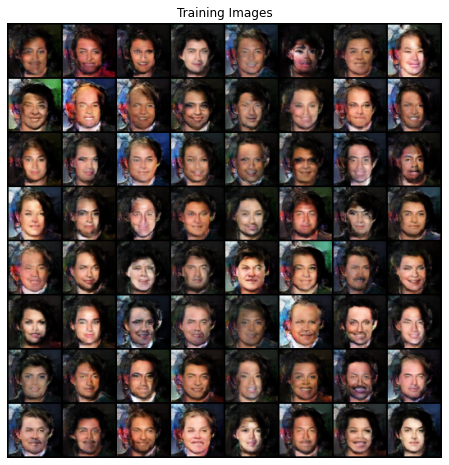

In [ ]:
list_image=[]
for i in range (0,5000,75):
    gen = denorm(nn_gen(attrs).squeeze())
    list_image.append(gen)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(list_image[:-3]).cpu(),(1,2,0)))


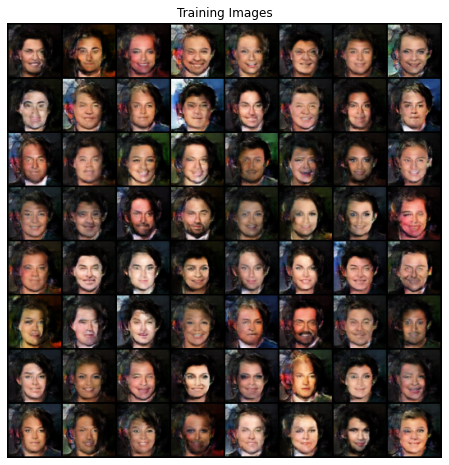

In [ ]:
list_image=[]
for i in range (0,5000,75):
    gen = denorm(nn_gen(attrs).squeeze())
    list_image.append(gen)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(list_image[:-3]).cpu(),(1,2,0)))
